In [1]:
import scanpy as sc
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score 
import numpy as np
import pandas as pd
import time
import mlpModel 
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
sc.settings.verbosity
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

### Prepping Data

In [3]:
#obtain data from file
adata =  sc.read_h5ad("data/Norman_2019.h5ad")  # replace with your path

In [96]:
adata.obs['perturbation_name'].iloc[0]

'control'

In [4]:
#export data from sc.read
ddata = adata.X.toarray()
labels = adata.obs['perturbation_name'].to_numpy()
parsed_labels = [p.split('+') if p != 'control' else [] for p in labels]

In [5]:
#multilabel encode the data 
mlb = MultiLabelBinarizer()
labels_int = mlb.fit_transform(parsed_labels)

In [14]:
#split data
X_train, X_test, y_train, y_test = train_test_split(
    ddata, 
    labels_int, 
    test_size=0.2, 
    random_state=67, #SIX SEVEENNNNNNNNNN
    #stratify=labels_int
)

In [15]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Running Model

In [33]:
input_size = X_train.shape[1] # Number of genes
num_classes = labels_int[0].size
learning_rate = 0.00026
num_epochs = 15

model = mlpModel.MLP(input_size=input_size, num_classes=num_classes)
criterion = nn.BCEWithLogitsLoss() # Best for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 2e-6)

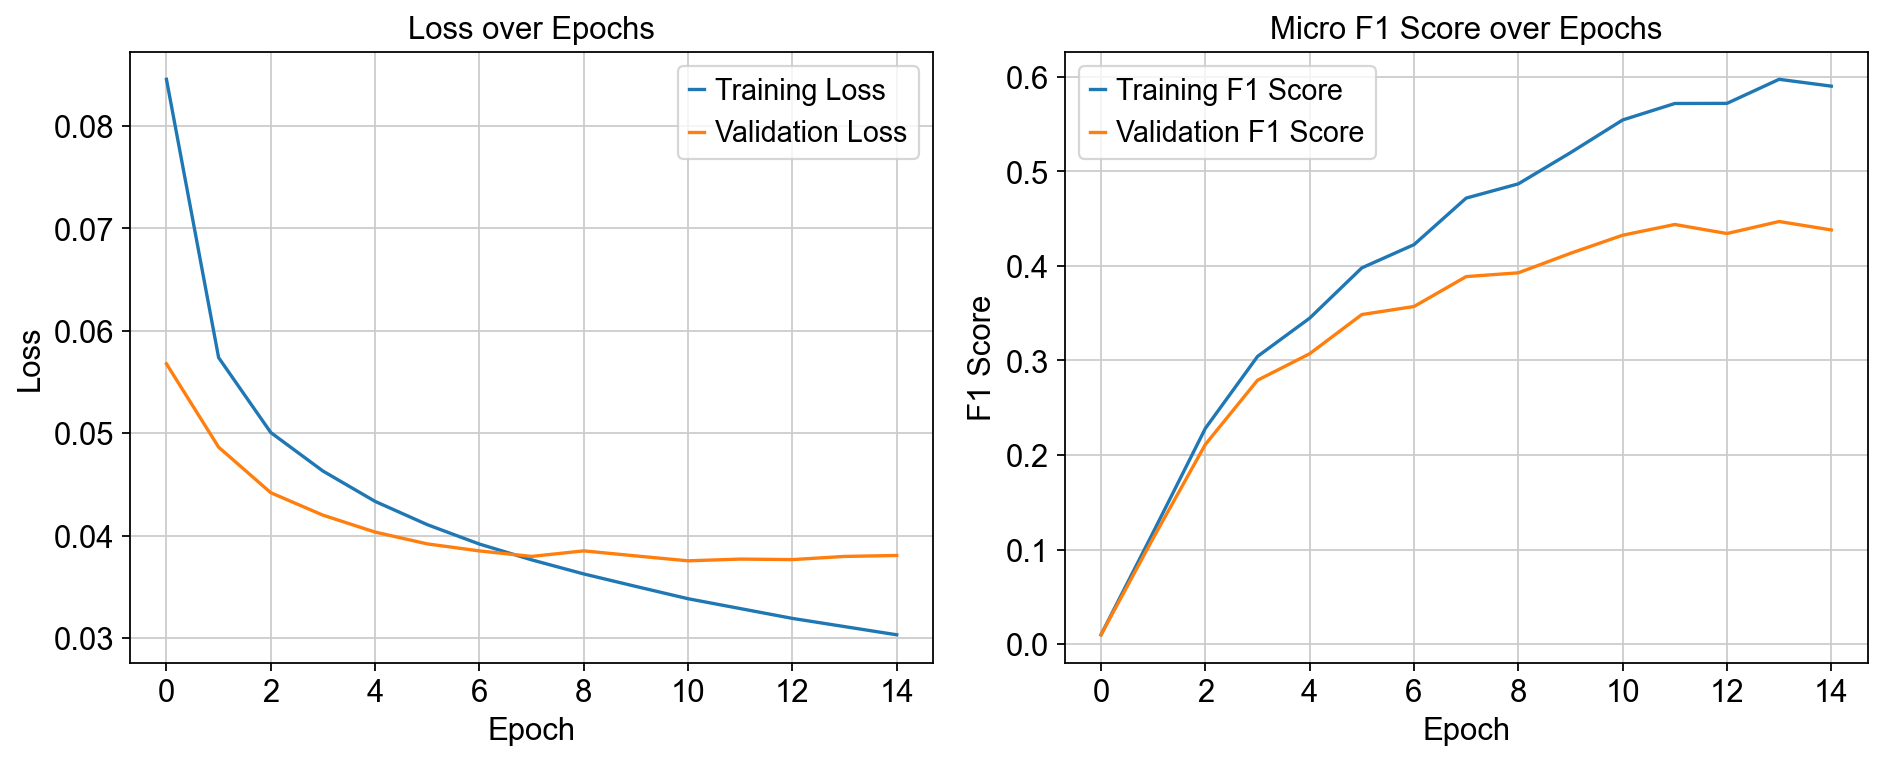

Epoch [15/15], Loss: 0.0375

Training Complete. Final Validation F1 Score: 0.4381


In [34]:
train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
display(fig)


for epoch in range(num_epochs):
    model.train()
    current_train_loss = 0.0
    for i, (features, labels) in enumerate(train_loader):
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
    train_losses.append(current_train_loss / len(train_loader))

    model.eval()
    current_test_loss = 0.0
    all_train_preds, all_train_labels = [], []
    all_test_preds, all_test_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_test_preds.append(preds.numpy())
            all_test_labels.append(labels.numpy())
        
        # Evaluate on training set (to compare train vs test performance)
        for inputs, labels in train_loader:
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_train_preds.append(preds.numpy())
            all_train_labels.append(labels.numpy())
        
    test_losses.append(current_test_loss / len(test_loader))
    
    # Calculate F1 score for this epoch
    train_f1 = f1_score(np.vstack(all_train_labels), np.vstack(all_train_preds), average='micro')
    test_f1 = f1_score(np.vstack(all_test_labels), np.vstack(all_test_preds), average='micro')
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    

    # Clear the previous plot
    ax1.clear()
    ax2.clear()
    
    # Plot Loss
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(test_losses, label='Validation Loss')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot F1 Score (Accuracy)
    ax2.plot(train_f1_scores, label='Training F1 Score')
    ax2.plot(test_f1_scores, label='Validation F1 Score')
    ax2.set_title('Micro F1 Score over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    
    fig.tight_layout()
    # Redraw the plot in the same cell
    clear_output(wait=True)
    display(fig)
    time.sleep(0.1) # Small pause to allow plot to render

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Close the figure after the loop is done
plt.close(fig)

print(f"\nTraining Complete. Final Validation F1 Score: {test_f1_scores[-1]:.4f}")



### Optimizing with Optuna

In [26]:
import optuna

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
def define_model(trial):
    """A helper function to define the model architecture based on the trial."""
    n_layers = trial.suggest_int('n_layers', 2, 10)
    layers = []
    in_features = X_train.shape[1]
    
    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_l{i}', 10, 100, log=True)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        dropout_p = trial.suggest_float(f'dropout_l{i}', 0.25, 0.5)
        layers.append(nn.Dropout(dropout_p))
        in_features = out_features
        
    layers.append(nn.Linear(in_features, num_classes))
    return nn.Sequential(*layers)

def objective(trial):
    """This is the main function Optuna will call for each trial."""
    
    # --- 1. Suggest Hyperparameters ---
    model = define_model(trial)
    lr = trial.suggest_float('lr', 1e-6, 1e-5, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-5, log=True)
    
    # --- 2. Setup Model and Optimizer ---
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # --- 3. Training and Evaluation Loop (Adapted from your code) ---
    num_epochs = 100
    patience = 10  # For early stopping
    patience_counter = 0
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        for features, labels in train_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # --- Validation Phase ---
        model.eval()
        all_test_preds, all_test_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                all_test_preds.append(preds.numpy())
                all_test_labels.append(labels.numpy())
        
        val_f1 = f1_score(np.vstack(all_test_labels), np.vstack(all_test_preds), average='micro')
        
        # --- Early Stopping and Pruning Logic ---
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Pruning: A feature of Optuna to stop unpromising trials early.
        trial.report(val_f1, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if patience_counter >= patience:
            break # Exit loop if no improvement

    # The objective function must return the score to be maximized
    return best_val_f1

In [49]:
# Create a study object and specify the direction as 'maximize'
study = optuna.create_study(direction='maximize')

# Start the optimization. Let's run it for 50 trials as an example.
study.optimize(objective, n_trials=50)

# --- 4. Get and Print the Best Results ---
print("\nStudy statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("\nBest trial:")
trial = study.best_trial

print(f"  Value (Best Validation F1 Score): {trial.value:.4f}")

print("  Best Hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-10-06 23:15:34,451] A new study created in memory with name: no-name-2a556331-334a-42db-baff-b834abe22050
[I 2025-10-06 23:16:50,201] Trial 0 finished with value: 0.02445585918772687 and parameters: {'n_layers': 8, 'n_units_l0': 91, 'dropout_l0': 0.43153575095083574, 'n_units_l1': 44, 'dropout_l1': 0.3165196996309646, 'n_units_l2': 10, 'dropout_l2': 0.3871504196332906, 'n_units_l3': 89, 'dropout_l3': 0.34633816069687673, 'n_units_l4': 14, 'dropout_l4': 0.2515550771463674, 'n_units_l5': 24, 'dropout_l5': 0.4400533775433322, 'n_units_l6': 45, 'dropout_l6': 0.27649685075863206, 'n_units_l7': 90, 'dropout_l7': 0.29866863130042187, 'lr': 3.1690260854271923e-06, 'weight_decay': 3.183332239438634e-06}. Best is trial 0 with value: 0.02445585918772687.
[I 2025-10-06 23:17:48,430] Trial 1 finished with value: 0.02471780008794636 and parameters: {'n_layers': 2, 'n_units_l0': 87, 'dropout_l0': 0.4420310819788029, 'n_units_l1': 22, 'dropout_l1': 0.49496133623667987, 'lr': 3.612854954269304e


Study statistics: 
  Number of finished trials:  50

Best trial:
  Value (Best Validation F1 Score): 0.0392
  Best Hyperparameters: 
    n_layers: 4
    n_units_l0: 10
    dropout_l0: 0.43130764597626065
    n_units_l1: 41
    dropout_l1: 0.46948578412682523
    n_units_l2: 45
    dropout_l2: 0.3741759303102088
    n_units_l3: 10
    dropout_l3: 0.275402864492326
    lr: 8.421851552640538e-06
    weight_decay: 5.376062599335938e-06


## Transformer